In [46]:
# 2025-07-01 simulates and fits the full noise model, including mixture model for outliers, and a 
# three-coefficient dependence of noise major axis on apparent magnitude.
#
# This example runs on data we generated in an earlier run.
#
# The actual MCMC run parameters are now set in an input parameter file, mcmc_fullnoise2_pars.ini
#
# test usage of npts input (to override parameter file for convenience, e.g. if that's all we're changing)

Comment: it's generally better NOT to run-all, but to run down to the first "examine2d.showguess" call, then CHECK whether the fit is giving sensible results.

# Import modules and determine a couple of arguments for this run

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool, cpu_count
import numpy as np
import matplotlib.pylab as plt
plt.ion()
from importlib import reload
import emcee
import time
import mcmc2d
import examine2d
import apply2d
import pickle

In [3]:
%matplotlib inline

In [4]:
# some strings we can change programmatically
npoints_arg = 40  # if simulating, change the number of stars. This appears in output filenames.
styp='fullnoise2'

## Do initial fit, set up for MCMC, and do any nonparametric bootstraps.

In [47]:
# param file now has c not log10(c). The acceptance fraction is quite low, so we rerun this with 6x the length.
#
# Note that any non-parametric bootstrapping happens in this step, so this can take a while to run if that
# is enabled.
esargs, runargs, showargs = mcmc2d.setupmcmc(pathconfig='mcmc_fullnoise2_pars.ini')

MCMCrun.loadconfig INFO - reading configuration from mcmc_fullnoise2_pars.ini
Imported truthset INFO: [-5.45327955e-01 -1.15892202e-02  1.88070429e-02  3.52509342e-01
 -6.88683671e-03 -1.05737756e-02 -6.50000000e+00 -6.00000000e+00
  3.16000000e+00  7.00000000e-01  2.00000000e-01 -1.00000000e+00
 -8.50000000e+00]
here: eg11_guess_mix_fullnoise2.ini
Guess.loadconfig WARN - parse problems with keywords: ['alpha0', 'delta0']
mcmc2d.doguess DEBUG: guess transf: []
mcmc2d.doguess DEBUG - initialized guess parset:
[0. 0. 0. 0. 0. 0.]
[-6. -6.  2.]
[0.9 0.1]
[ -1.1 -10. ]
Guess degree: 1
mcmc2d.doguess DEBUG =======
PROPAG COVAR DEBUG:
[[ 1.18409608e-12 -6.12825348e-15]
 [-6.12825348e-15  3.23846955e-13]]
[[4.47772538e-13 2.68663523e-14]
 [2.68663523e-14 1.61198114e-13]]
fit2d.Guess.updatelsq_covars INFO - re-fitting the lsq with propagated covars
fit2d.Guess.updatelsq_covars INFO - before and after:
[[[ 2.25583510e+12 -3.75972517e+11]
  [-3.75972517e+11  6.26620862e+12]]

 [[ 1.38895148e+12 

showguess DEBUG - bbg: 4


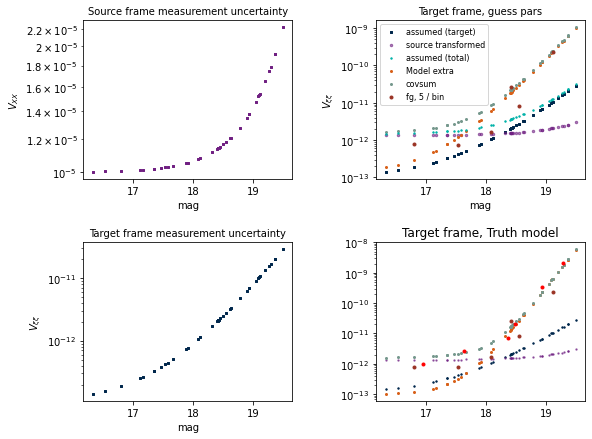

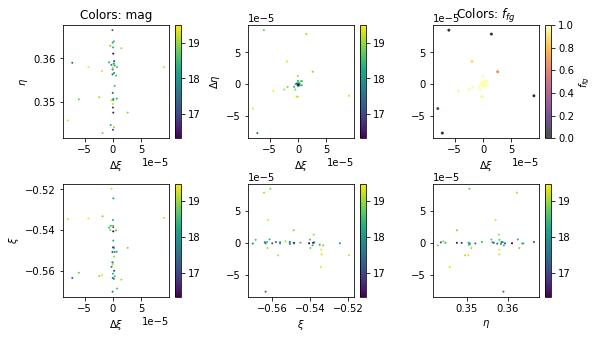

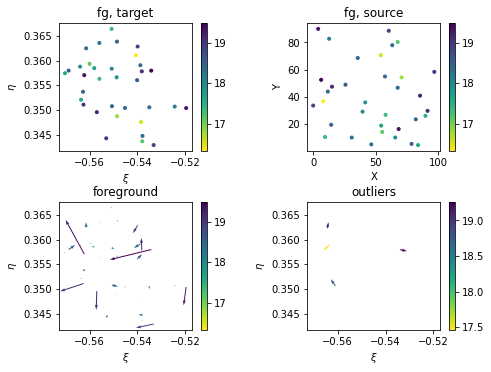

In [21]:
examine2d.showguess(esargs, nmagbins=6, showargs=showargs)

In [22]:
#esargs['args'][0].parsx

In [23]:
# local changes to showguess
# runargs.keys()

# Run the MCMC sampler and put the results into a "Flatsamples" object

  0%|          | 0/80000 [00:00<?, ?it/s]/Users/wiclarks/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 80000/80000 [31:24<00:00, 42.46it/s]


mcmc2d.getflatsamples INFO - measuring autocorrelation time:
mcmc2d.getflatsamples INFO - max autocorr time: 3.18e+02
mcmc2d.getflatsamples INFO - mean acceptance fraction: 0.33231517857142856 (28,) 0.3249 0.3391625
mcmc2d.getflatsamples INFO - retaining samples with finite lnprob 13048 13048
mcmc2d.getflatsamples INFO - flat samples shape: (13048, 13)
examine2d.showcorner INFO - plotting corner plot...
examine2d.showcorner INFO - highlighting nuisance parameters
examine2d.computeresps INFO - starting responsibility loop...
examine2d.computeresps INFO - iteration 13000 of 13048 after 1.79e+01 seconds: 725.5 it/sec. Est 6.62e-02 sec remain
examine2d.computeresps INFO - loops took 1.80e+01 seconds for 1.30e+04 samples
examine2d.writeresps INFO - writing responsibilities: (13048, 40)
computesamplescovars INFO - covs shape: (13048, 40, 2, 2)
computesamplescovars INFO - iteration 13000 of 13048 after 1.43e+01 seconds: 908.9 it/sec. Est 5.28e-02 sec remain
computesamplescovars INFO - computi

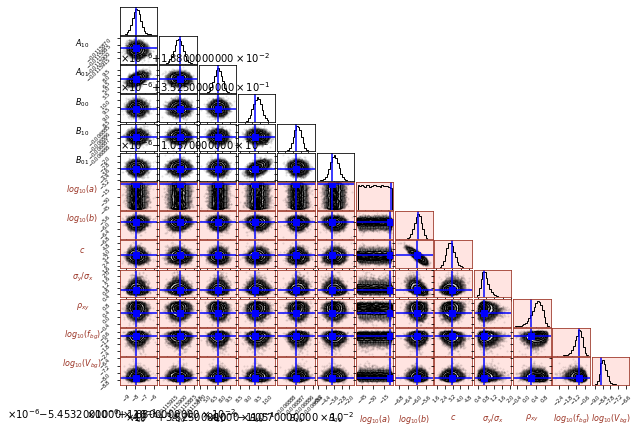

In [24]:
# OK so plots appear to work. Now try the sampling!
with Pool() as pool:
    sampler = emcee.EnsembleSampler(**esargs, pool=pool)
    sampler.run_mcmc(**runargs)
    flat_samples, lnprobs = mcmc2d.getflatsamples(sampler, \
                                                  pathflat='eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                                                 pathprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp))
    examine2d.showcorner(flat_samples, **showargs['corner'], pathfig='eg11_twoframe_corner_n%i_%s.png' % (npoints_arg, styp))
    FS = examine2d.Flatsamples(flat_samples, esargs=esargs, log_probs=lnprobs, showargs=showargs)
    FS.computeresps()
    FS.computesamplescovars()

In [25]:
# write the "results" and the whole sampler to disk
FS.saveparset('test_parset_medians.pickle')
with open('test_sampler.pickle','wb') as wobj:
    pickle.dump(sampler, wobj)

# Interrogate the results using the flat samples

examine2d.showcorner INFO - plotting corner plot...
examine2d.showcorner INFO - highlighting nuisance parameters


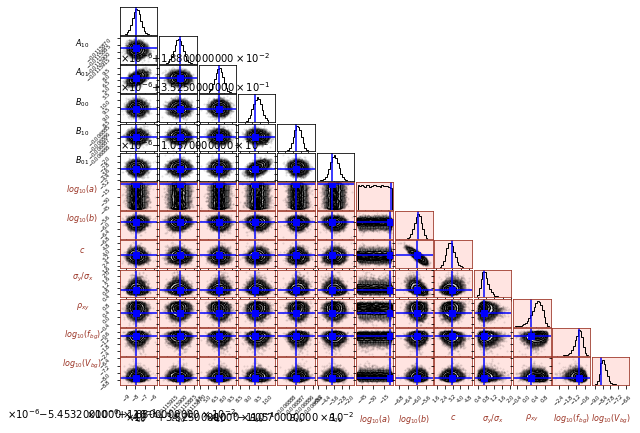

In [26]:
# Now try doing a corner-plot of only the "main" blob:
bmain = FS.ismain
examine2d.showcorner(flat_samples[bmain], **showargs['corner'], pathfig='eg11_twoframe_corner_mainclust_n%i_%s.png' % (npoints_arg, styp))

In [27]:
print(np.sum(bmain), np.size(bmain))

13045 13048


In [28]:
# Compare covariance to lstsq
examine2d.showcovarscomp(FS)

showcovarscomp WARN - key not in dictionary: covpars


In [29]:
# some filename carpentry (save effort re-typing)
pathpset = 'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp)
pathpguess = 'eg11_test_parset_guess_n%i_%s.txt' % (npoints_arg, styp)
pathsrc = 'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp)
pathtarg = 'eg11_test_obs_targ_n%i_%s.dat' % (npoints_arg, styp)

pathshowargs = 'eg11_n%i_%s_test_showargs.pickle' % (npoints_arg, styp)
pathrunargs = 'eg11_n%i_%s_test_runargs.pickle' % (npoints_arg, styp)
pathesargs = 'eg11_n%i_%s_test_esargs.pickle' % (npoints_arg, styp)

os.rename('test_parset_truth.txt',pathpset)
os.rename('test_parset_guess.txt',pathpguess)
os.rename('test_obs_src.dat', pathsrc)
os.rename('test_obs_targ.dat', pathtarg)

os.rename('test_showargs.pickle', pathshowargs)
os.rename('test_runargs.pickle', pathrunargs)
os.rename('test_esargs.pickle', pathesargs)

In [30]:
# copy some files across in order for the following to play nice
#!cp -p test_parset_truth.txt eg10_test_parset_truth_n300_fullnoise.txt
#!cp -p test_parset_guess.txt eg10_test_parset_guess_n300_fullnoise.txt
#!cp -p test_obs_src.dat eg10_test_obs_src_n300_fullnoise.dat

#!cp -p test_showargs.pickle eg10_fullnoise_test_showargs.pickle
#!cp -p test_runargs.pickle eg10_fullnoise_test_runargs.pickle
#!cp -p test_esargs.pickle eg10_fullnoise_test_esargs.pickle

In [31]:
fsfile='eg11_n%i_%s_flatsamples.pickle' % (npoints_arg, styp)
pickle.dump(FS, open(fsfile, 'wb'))

eg11_test_parset_truth_n40_fullnoise2.txt Poly
[0 1 2 3 4 5]
traceplot DBG: (13048, 13) (13048,)
eg11_mix_twoframe_flatsamples_n40_fullnoise2.npy
eg11_mix_twoframe_lnprobs_n40_fullnoise2.npy
DBG: grid line IDs:
300
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
samples_z DEBUG: (1000, 300) (13048,)
300000
(1000, 300)


(0.35, 0.355)

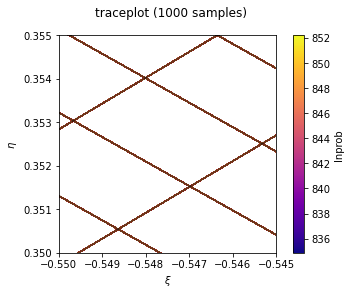

In [32]:
# apply local changes
reload(apply2d)

# Try a traceplot - may be hard to see the range for this example...
apply2d.traceplot(1000,'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp),\
                  'eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                 pathlnprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp), \
                 scmap='plasma')
plt.gca().set_xlim(-0.55,-0.545)
plt.gca().set_ylim(0.350,0.355)

In [33]:
# apply some changes made locally between runs
reload(apply2d)

<module 'apply2d' from '/Users/wiclarks/Projects/random-prototypes/python/apply2d.py'>

eg11_test_parset_guess_n40_fullnoise2.txt Poly
sample_uncty INFO - starting 2.50e+03 flat samples...
sample_uncty INFO - ... done in 2.22e+00 seconds
sample_uncty INFO - starting 2.50e+03 MC samples...
sample_uncty INFO - ... done in 1.42e+00 seconds
(40,) (40,) (40,)


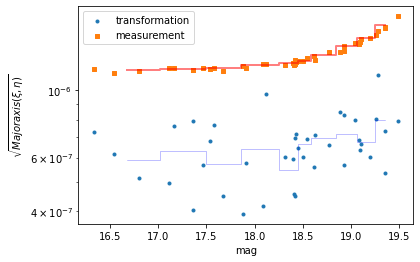

In [34]:
# Compare transformation uncertainty with pointing uncertainty
apply2d.eval_uncty(2500,'eg11_test_parset_guess_n%i_%s.txt' % (npoints_arg, styp), \
                   'eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp),\
                   'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp), nbins=10)

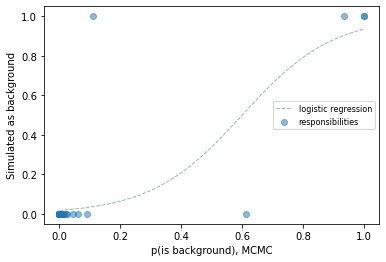

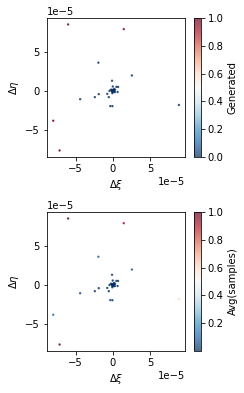

In [35]:
# incorporate local edits
# reload(examine2d)

# Since this was a mixture model, show the responsibilities
examine2d.showresps(FS)

showparsamples DEBUG: [1 2 3 5 4 6] 6 6


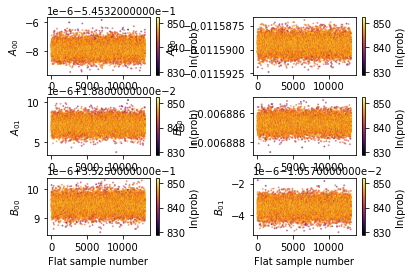

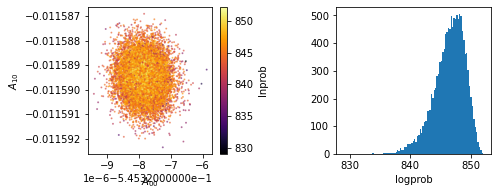

In [36]:
examine2d.showparsamples(FS)

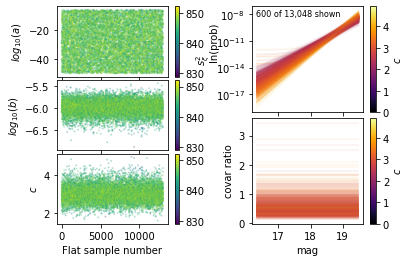

In [37]:
# shownoisesamples only makes sense if noise vs mag...
examine2d.shownoisesamples(FS, nshow=600, alpha=0.08, cmap='inferno', jaux=2)

eg11_test_parset_truth_n40_fullnoise2.txt Poly
sample_transf INFO - running samples...
sample_transf INFO - ... done.
[ 0  1 15  3] [1. 1. 0. 1.]


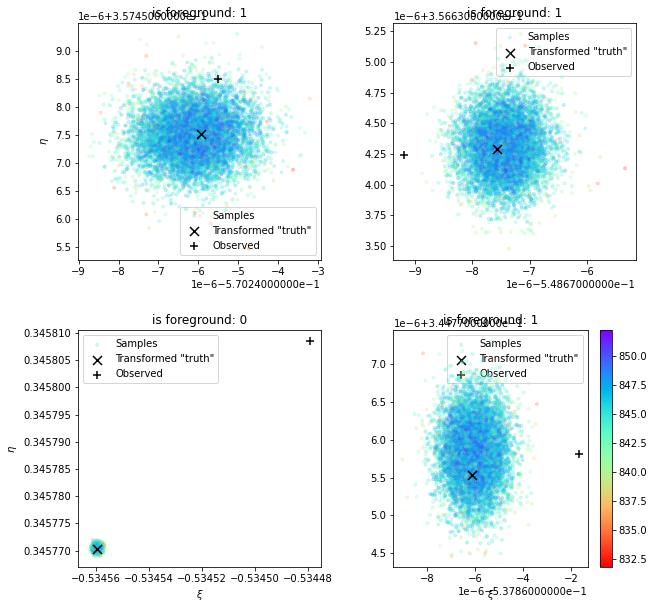

In [38]:
reload(apply2d)
apply2d.sample_transf(8000, pathpset='eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp), \
                      pathflat='eg11_mix_twoframe_flatsamples_n%i_%s.npy' % (npoints_arg, styp), \
                      pathobs='eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp), \
                 pathlnprobs='eg11_mix_twoframe_lnprobs_n%i_%s.npy' % (npoints_arg, styp), alpha=0.2,\
                     pathtarg='eg11_test_obs_targ_n%i_%s.dat' % (npoints_arg, styp))

showunctysamples INFO - mags, pctiles, levels: (40,) (5,) (5, 40, 2, 2)


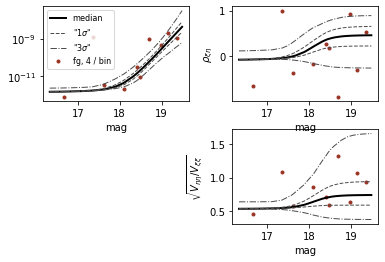

In [39]:
# how do those uncertainty bins look as percentiles?
examine2d.showunctysamples(FS)

eg11_test_parset_truth_n40_fullnoise2.txt Poly
unctysamples INFO - transformation name: Poly
unctysamples INFO - starting 5.00e+03 MC samples...
... done in 2.82e+00 seconds
Computing moments...

... done in 2.48e-02 seconds.
(40, 2)
(40, 2)
(40, 2, 2)
(0,)
Offset INFO - median offset: [-2.46289356e-09 -3.84406951e-09]
lsq pars: [ 3.59034756e-07  1.00000035e+00 -4.76561679e-07  8.26676351e-08
  1.81084379e-07  1.00000005e+00]
lsq geom: [ 3.59034756e-07  8.26676351e-08  1.00000035e+00  1.00000005e+00
 -1.88401693e-05 -1.69296046e-05]
===== Transformed covariances =====
Covariances of propagated positions:
majors computed: [1.39899410e-12 1.41050206e-12 1.41700245e-12 1.54202750e-12]
minors computed: [3.66341150e-13 3.78789587e-13 3.71120972e-13 4.18180272e-13]
posans computed: [-2.3124971  -3.85616757 -3.71471129 -3.90023171]
Propagated covariances of input positions
majors propag: [1.39712341e-12 1.42702243e-12 1.37594149e-12 1.55448726e-12]
minors propag: [3.73977321e-13 3.81980590e-1

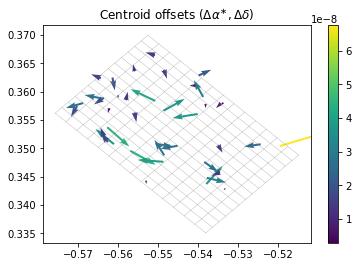

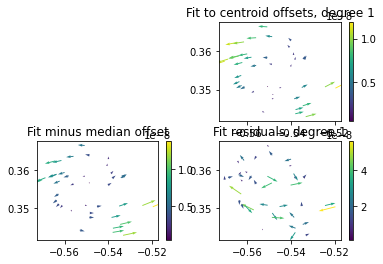

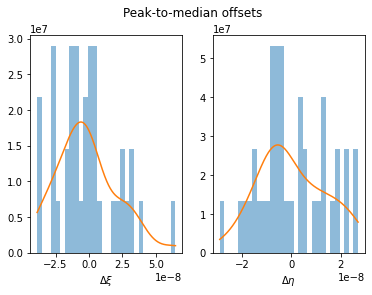

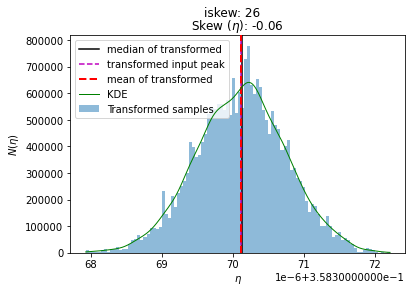

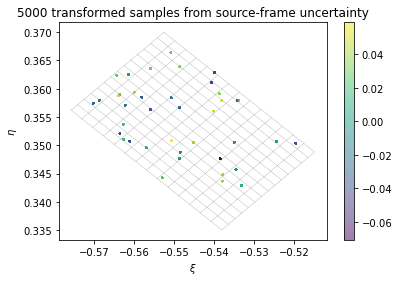

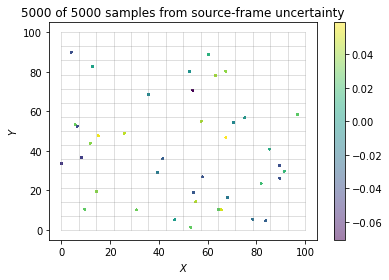

In [40]:
# Now draw samples from the projected uncertainty
apply2d.unctysamples(5000, \
                     'eg11_test_parset_truth_n%i_%s.txt' % (npoints_arg, styp),\
                     'eg11_test_obs_src_n%i_%s.dat' % (npoints_arg, styp))

In [41]:
showargs['corner']

{'truths': array([-5.45327955e-01, -1.15892202e-02,  1.88070429e-02,  3.52509342e-01,
        -6.88683671e-03, -1.05737756e-02, -6.50000000e+00, -6.00000000e+00,
         3.16000000e+00,  7.00000000e-01,  2.00000000e-01, -1.00000000e+00,
        -8.50000000e+00]),
 'labels': ['$A_{00}$',
  '$A_{10}$',
  '$A_{01}$',
  '$B_{00}$',
  '$B_{10}$',
  '$B_{01}$',
  '$log_{10}(a)$',
  '$log_{10}(b)$',
  '$c$',
  '$\\sigma_y/\\sigma_x$',
  '$\\rho_{xy}$',
  '$log_{10}(f_{bg})$',
  '$log_{10}(V_{bg})$'],
 'nmodel': 6,
 'inds_abc': array([0, 1, 2, 3, 4, 5])}

In [42]:
FS.ismain.size

13048

In [43]:
FS.flat_samples.shape

(13048, 13)

In [44]:
FS.flat_samples[FS.ismain,:].shape

(13045, 13)